In [14]:

!pip install minisom
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Allow uploads
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart (1).csv


In [15]:
# Load the dataset
data = pd.read_csv('heart.csv')

# Split into train and test sets (820 train, 205 test)
train_data = data.iloc[:820, :].copy()
test_data = data.iloc[820:, :].copy()

# Save index for identification
train_data['index'] = train_data.index
test_data['index'] = test_data.index


# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data.drop(columns=['index']))
X_test = scaler.transform(test_data.drop(columns=['index']))




In [16]:
# Initialize SOM
som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_train)

# Train SOM
som.train_random(data=X_train, num_iteration=1000)

In [17]:
# Map each sample to its BMU (Best Matching Unit)
mapped_coords = np.array([som.winner(x) for x in X_train])
train_data['bmu_x'] = mapped_coords[:, 0]
train_data['bmu_y'] = mapped_coords[:, 1]

In [18]:
# Features associated with heart attack risk
risk_factors = ['chol', 'trestbps', 'thalach', 'oldpeak', 'exang', 'cp']

# Group by neuron (BMU) coordinates
cluster_profiles = train_data.groupby(['bmu_x', 'bmu_y'])[risk_factors].mean().reset_index()

# Add patient count per cluster
cluster_profiles['count'] = train_data.groupby(['bmu_x', 'bmu_y']).size().values

# Compute risk score based on feature weighting
def compute_risk_score(row):
    return (
        row['chol'] * 0.25 +
        row['trestbps'] * 0.25 +
        (1 - row['thalach']) * 0.2 +
        row['oldpeak'] * 0.15 +
        row['exang'] * 0.1 +
        (1 - row['cp']) * 0.05
    )

cluster_profiles['risk_score'] = cluster_profiles.apply(compute_risk_score, axis=1)

# Show top 10 riskiest clusters
high_risk_clusters = cluster_profiles.sort_values(by='risk_score', ascending=False)
high_risk_clusters.head(10)

,bmu_x,bmu_y,chol,trestbps,thalach,oldpeak,exang,cp,count,risk_score
26,4,0,564.000000,115.000000,160.000000,1.600000,0.0,2.000000,3,138.140000
45,6,6,326.000000,170.000000,140.000000,3.400000,1.0,0.000000,3,96.860000
50,7,6,294.000000,138.000000,106.000000,1.900000,0.0,0.000000,3,87.335000
29,4,5,269.000000,160.000000,112.000000,2.900000,1.0,2.000000,3,85.535000
2,0,2,318.285714,132.000000,145.857143,1.714286,1.0,0.428571,7,83.985714
56,8,5,318.000000,114.000000,140.000000,4.400000,0.0,0.000000,3,80.910000
54,8,2,288.000000,126.517241,118.965517,2.000000,1.0,0.000000,29,80.486207
7,0,9,283.000000,192.000000,195.000000,0.000000,0.0,1.000000,3,79.950000
1,0,1,248.727273,183.090909,146.454545,2.745455,1.0,0.000000,11,79.425455
9,1,1,295.181818,139.818182,149.454545,0.745455,1.0,0.000000,11,79.320909


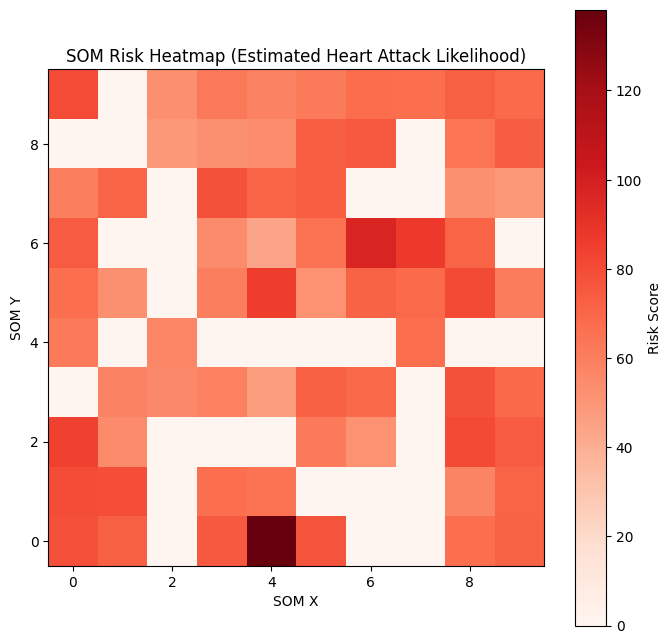

In [19]:
# Create grid for visualization
risk_grid = np.zeros((10, 10))

for _, row in cluster_profiles.iterrows():
    x, y = int(row['bmu_x']), int(row['bmu_y'])
    risk_grid[x, y] = row['risk_score']

# Plot heatmap
plt.figure(figsize=(8, 8))
plt.imshow(risk_grid.T, cmap='Reds', origin='lower')
plt.colorbar(label='Risk Score')
plt.title('SOM Risk Heatmap (Estimated Heart Attack Likelihood)')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.grid(False)
plt.show()

In [20]:
# Choose top 5 risky clusters
top_clusters = high_risk_clusters.head(5)[['bmu_x', 'bmu_y']].values.tolist()

# Find patients that mapped to those neurons
high_risk_patients = train_data[train_data[['bmu_x', 'bmu_y']].apply(tuple, axis=1).isin([tuple(x) for x in top_clusters])]
high_risk_patients[['index'] + risk_factors]

,index,chol,trestbps,thalach,oldpeak,exang,cp
4,4,294,138,106,1.9,0,0
11,11,341,132,136,3.0,1,0
33,33,269,160,112,2.9,1,2
70,70,326,170,140,3.4,1,0
158,158,564,115,160,1.6,0,2
165,165,326,170,140,3.4,1,0
192,192,564,115,160,1.6,0,2
240,240,288,132,159,0.0,1,1
312,312,269,160,112,2.9,1,2
370,370,341,132,136,3.0,1,0


In [21]:

##This line maps each sample in your test dataset to its Best Matching Unit (BMU) on the already trained SOM, and retrieves their coordinates.
mapped_coords_test = np.array([som.winner(x) for x in X_test])
test_data['bmu_x'] = mapped_coords_test[:, 0]
test_data['bmu_y'] = mapped_coords_test[:, 1]


risk_factors = ['chol', 'trestbps', 'thalach', 'oldpeak', 'exang', 'cp']


cluster_profiles_test = test_data.groupby(['bmu_x', 'bmu_y'])[risk_factors].mean().reset_index()


cluster_profiles_test['count'] = test_data.groupby(['bmu_x', 'bmu_y']).size().values


def compute_risk_score(row):
    return (
        row['chol'] * 0.25 +
        row['trestbps'] * 0.25 +
        (1 - row['thalach']) * 0.2 +
        row['oldpeak'] * 0.15 +
        row['exang'] * 0.1 +
        (1 - row['cp']) * 0.05
    )

cluster_profiles_test['risk_score'] = cluster_profiles_test.apply(compute_risk_score, axis=1)


high_risk_clusters_test = cluster_profiles_test.sort_values(by='risk_score', ascending=False)
high_risk_clusters_test.head(10)

,bmu_x,bmu_y,chol,trestbps,thalach,oldpeak,exang,cp,count,risk_score
6,1,1,322.500000,136.000000,151.000000,1.050000,1.0,0.0,2,84.932500
43,8,5,318.000000,114.000000,140.000000,4.400000,0.0,0.0,1,80.910000
26,5,3,267.333333,166.333333,139.000000,0.833333,0.0,3.0,6,80.841667
13,3,0,300.250000,145.000000,157.750000,3.450000,0.0,0.0,4,80.530000
25,5,0,300.200000,136.200000,147.400000,0.360000,0.0,2.0,5,79.824000
5,1,0,297.000000,144.000000,161.500000,0.900000,1.0,0.0,2,78.435000
15,3,3,314.500000,134.000000,176.000000,0.000000,0.0,1.5,2,77.100000
55,9,9,289.333333,138.333333,152.000000,1.000000,0.0,2.0,3,76.816667
22,4,7,277.000000,127.333333,125.333333,1.700000,1.0,0.0,3,76.621667
44,8,6,241.000000,133.333333,103.333333,1.166667,0.0,2.0,3,73.241667


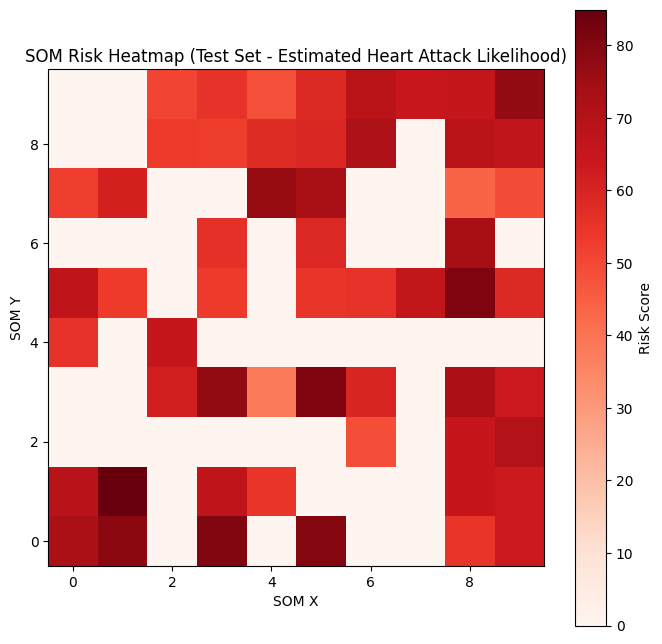

,index,chol,trestbps,thalach,oldpeak,exang,cp
821,821,268,140,160,3.6,0,0
843,843,273,160,125,0.0,0,3
848,848,283,150,162,1.0,0,3
862,862,288,170,159,0.2,0,3
864,864,273,160,125,0.0,0,3
872,872,227,170,155,0.6,0,3
874,874,273,160,125,0.0,0,3
888,888,258,150,157,2.6,0,0
889,889,407,150,154,4.0,0,0
896,896,270,178,145,4.2,0,3


In [22]:
# Create grid for visualization
risk_grid_test = np.zeros((10, 10))

for _, row in cluster_profiles_test.iterrows():
    x, y = int(row['bmu_x']), int(row['bmu_y'])
    risk_grid_test[x, y] = row['risk_score']

# Plot heatmap
plt.figure(figsize=(8, 8))
plt.imshow(risk_grid_test.T, cmap='Reds', origin='lower')
plt.colorbar(label='Risk Score')
plt.title('SOM Risk Heatmap (Test Set - Estimated Heart Attack Likelihood)')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.grid(False)
plt.show()

# Choose top 5 risky clusters
top_clusters_test = high_risk_clusters_test.head(5)[['bmu_x', 'bmu_y']].values.tolist()

# Find test patients that mapped to those neurons
high_risk_test_patients = test_data[test_data[['bmu_x', 'bmu_y']].apply(tuple, axis=1).isin([tuple(x) for x in top_clusters_test])]
high_risk_test_patients[['index'] + risk_factors]

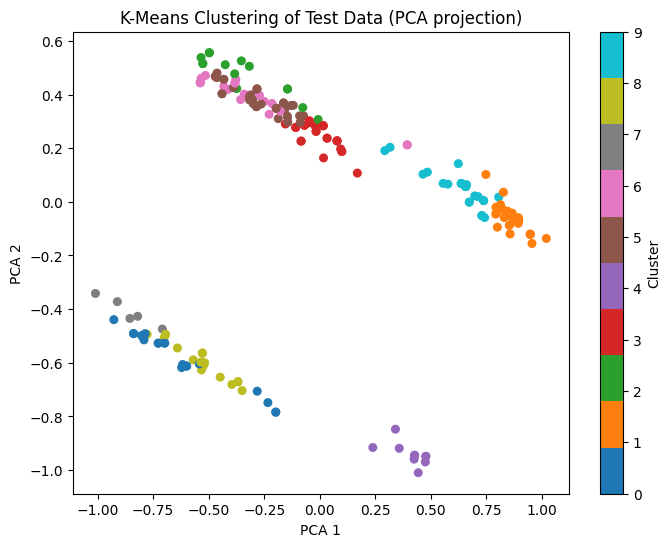

,index,chol,trestbps,thalach,oldpeak,exang,cp
820,820,207,140,138,1.9,1,0
821,821,268,140,160,3.6,0,0
822,822,253,130,144,1.4,1,0
824,824,166,138,125,3.6,1,0
825,825,252,135,172,0.0,0,2
...,...,...,...,...,...,...,...
1015,1015,216,128,131,2.2,1,0
1017,1017,282,123,95,2.0,1,0
1020,1020,221,140,164,0.0,1,1
1021,1021,258,125,141,2.8,1,0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Train K-Means on training data
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_train)

# Predict test data clusters
kmeans_labels = kmeans.predict(X_test)
test_data['kmeans_cluster'] = kmeans_labels

# Group by K-Means clusters
kmeans_profiles = test_data.groupby('kmeans_cluster')[risk_factors].mean().reset_index()
kmeans_profiles['count'] = test_data.groupby('kmeans_cluster').size().values
kmeans_profiles['risk_score'] = kmeans_profiles.apply(compute_risk_score, axis=1)

# Visualize K-Means clusters using PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30)
plt.title('K-Means Clustering of Test Data (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Show top 5 riskiest K-Means clusters
high_risk_kmeans_clusters = kmeans_profiles.sort_values(by='risk_score', ascending=False)
high_risk_kmeans_clusters.head(5)

# Identify patients in top 5 risky K-Means clusters
top_kmeans_clusters = high_risk_kmeans_clusters.head(5)['kmeans_cluster'].tolist()
high_risk_kmeans_patients = test_data[test_data['kmeans_cluster'].isin(top_kmeans_clusters)]
high_risk_kmeans_patients[['index'] + risk_factors]
